# Predicting Housing Prices

The goal of this notebook is to try and predict the SalesPrice of homes in Ames, Iowa. As per the Kaggle rules this will require some **feature engineering** as well as the usage of **Random Forest** models.

The approach I will take is as follows:
1. Import the data
2. Identify any strong correlations in the data
3. Determine if there are missing values
4. Remove features that are mostly null
5. Impute remaining features with mean data (numerical) and most frequent data (categorical)
6. Scale the data if needed


The kaggle competition page can be found [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

**Key Things to Use**
1. Random Forest
2. Cross Validation
3. Feature Engineering

## Import all the goodies

In [176]:
# data handling and prediction
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals.six import StringIO
from sklearn.model_selection import GridSearchCV
from scipy import stats


#visualization
%matplotlib inline
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt
import pydotplus

In [2]:
housing_data_train = pd.read_csv("../data/train.csv",na_values='NA')
housing_data_test = pd.read_csv("../data/test.csv",na_values='NA') #does not contain Saleprice column which is what we predict
# Convert the headers to lowercase
housing_data_train.columns = map(str.lower, housing_data_train.columns)
housing_data_test.columns = map(str.lower, housing_data_test.columns)

## Let's do some exploration

In [3]:
housing_data_train.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Lets take a look at the stats for the numerical data**

In [4]:
housing_data_train.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Correlation
Lets take a look at the correlation of the features to see if we can identify the important ones

In [7]:
housing_data_train.corr()["saleprice"].sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
1stflrsf         0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
2ndflrsf         0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
screenporch      0.111447
poolarea         0.092404
mosold           0.046432
3ssnporch        0.044584
bsmtfinsf2      -0.011378
bsmthalfbath    -0.016844
miscval         -0.021190
id              -0.021917
lowqualfinsf    -0.025606
yrsold          -0.028923
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.128578
kitchenabvgr    -0.135907
Name: salepr

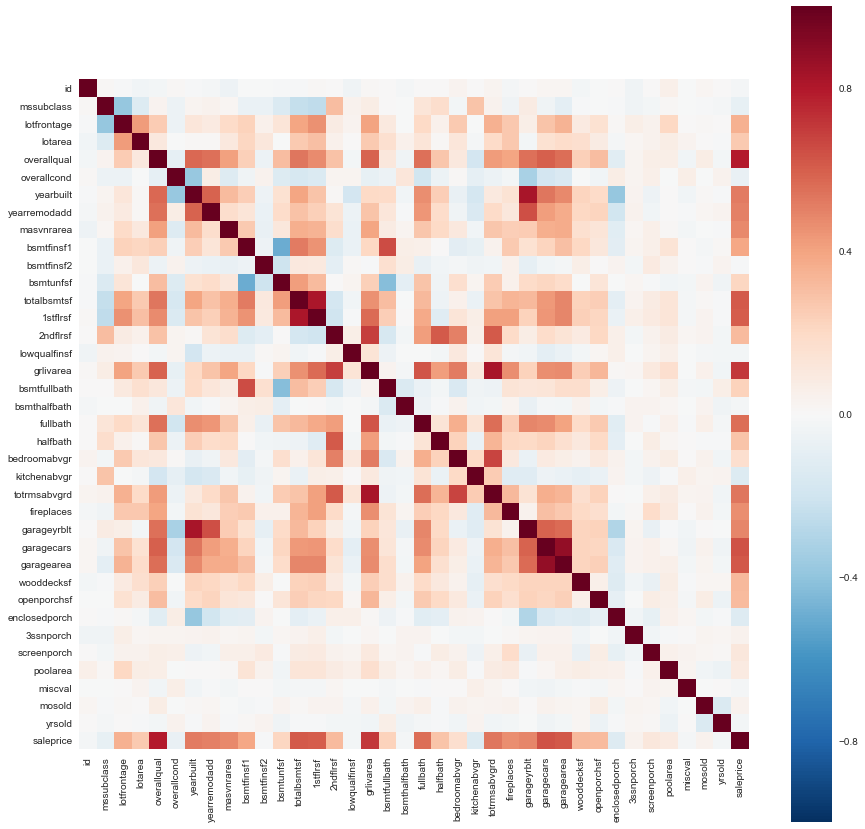

In [8]:
housing_corr = housing_data_train.corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(housing_corr, square=True)

Let's select the fields with a correlation of .4 or higher and see how the relationship to SalePrice looks.

In [65]:
important_features = ['overallqual','grlivarea','garagecars','garagearea','totalbsmtsf',
                      '1stflrsf','fullbath','totrmsabvgrd','yearbuilt','yearremodadd',
                      'garageyrblt','masvnrarea','fireplaces','saleprice']


## Checking Skew of the Data

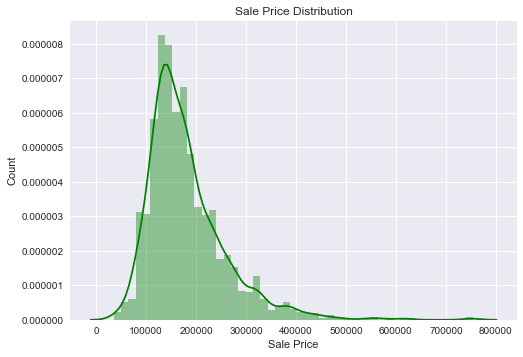

In [66]:
#histogram to view distribution of Salesprice
sns.distplot(housing_data_train["saleprice"],color="g")
plt.title("Sale Price Distribution")
plt.ylabel("Count")
plt.xlabel("Sale Price");

Looks like a positive skew. Let's check

In [67]:
print("Skew: %f" % housing_data_train['saleprice'].skew())

Skew: 1.882876


## Impute Missing data and correct Skew
Since our data seems to be so heavily skewed we will need to do the following:
1. Separate the numeric and categorical data
2. Impute Missing Data
3. Add a small numer to numerical data set to avoid issues with log function
4. Run log function to remove skew from data
5. Convert categorical data to indicator variables
6. Rejoin datasets

In [71]:
housing_data_train_numeric = housing_data_train.select_dtypes(include=['int64','float64'])

In [72]:
#housing_data_train_numeric = housing_data_train_numeric.drop('saleprice',axis=1)

In [73]:
housing_data_train_categories = housing_data_train.select_dtypes(exclude=['int64','float64'])

In [74]:
housing_data_train_categories.head()

,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,...,garagetype,garagefinish,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,saletype,salecondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [75]:
percent_null = (housing_data_train_categories.isnull().sum()/
                housing_data_train.isnull().count())

percent_null.sort_values(ascending=False)

poolqc           0.995205
miscfeature      0.963014
alley            0.937671
fence            0.807534
fireplacequ      0.472603
garagecond       0.055479
garagefinish     0.055479
garagetype       0.055479
garagequal       0.055479
bsmtexposure     0.026027
bsmtfintype2     0.026027
bsmtqual         0.025342
bsmtcond         0.025342
bsmtfintype1     0.025342
masvnrtype       0.005479
electrical       0.000685
condition2       0.000000
exterior2nd      0.000000
exterior1st      0.000000
extercond        0.000000
mszoning         0.000000
condition1       0.000000
centralair       0.000000
saletype         0.000000
bldgtype         0.000000
exterqual        0.000000
salecondition    0.000000
neighborhood     0.000000
foundation       0.000000
functional       0.000000
                   ...   
bsmtunfsf             NaN
enclosedporch         NaN
fireplaces            NaN
fullbath              NaN
garagearea            NaN
garagecars            NaN
garageyrblt           NaN
grlivarea   

Since some of our features are missing a large percentage of their data we will just drop them.

In [76]:
drop_columns = ['alley','poolqc','fence','miscfeature', 'fireplacequ']
for column in drop_columns:
    housing_data_train_categories = housing_data_train_categories.drop(column, axis=1)

Now let's check the null data in the numeric features.

In [77]:
numeric_percent_null = housing_data_train_numeric.isnull().sum()/housing_data_train_numeric.isnull().count()
numeric_percent_null.sort_values(ascending=False)

lotfrontage      0.177397
garageyrblt      0.055479
masvnrarea       0.005479
bsmtfinsf1       0.000000
lowqualfinsf     0.000000
2ndflrsf         0.000000
1stflrsf         0.000000
totalbsmtsf      0.000000
bsmtunfsf        0.000000
bsmtfinsf2       0.000000
saleprice        0.000000
bsmtfullbath     0.000000
yearremodadd     0.000000
yearbuilt        0.000000
overallcond      0.000000
overallqual      0.000000
lotarea          0.000000
mssubclass       0.000000
grlivarea        0.000000
bsmthalfbath     0.000000
yrsold           0.000000
fullbath         0.000000
mosold           0.000000
miscval          0.000000
poolarea         0.000000
screenporch      0.000000
3ssnporch        0.000000
enclosedporch    0.000000
openporchsf      0.000000
wooddecksf       0.000000
garagearea       0.000000
garagecars       0.000000
fireplaces       0.000000
totrmsabvgrd     0.000000
kitchenabvgr     0.000000
bedroomabvgr     0.000000
halfbath         0.000000
id               0.000000
dtype: float

Since lot frontage is missing over 17% of the data I will just drop it.

In [78]:
housing_data_train_numeric = housing_data_train_numeric.drop('lotfrontage', axis=1)

## Impute numeric data with the mean value

In [79]:
mean_per_column = housing_data_train_numeric.apply(lambda x: x.mean(),axis=0)
numeric_mean_filled = housing_data_train_numeric.fillna(mean_per_column,axis=0)
numeric_mean_filled.isnull().sum()

id               0
mssubclass       0
lotarea          0
overallqual      0
overallcond      0
yearbuilt        0
yearremodadd     0
masvnrarea       0
bsmtfinsf1       0
bsmtfinsf2       0
bsmtunfsf        0
totalbsmtsf      0
1stflrsf         0
2ndflrsf         0
lowqualfinsf     0
grlivarea        0
bsmtfullbath     0
bsmthalfbath     0
fullbath         0
halfbath         0
bedroomabvgr     0
kitchenabvgr     0
totrmsabvgrd     0
fireplaces       0
garageyrblt      0
garagecars       0
garagearea       0
wooddecksf       0
openporchsf      0
enclosedporch    0
3ssnporch        0
screenporch      0
poolarea         0
miscval          0
mosold           0
yrsold           0
saleprice        0
dtype: int64

In [80]:
housing_data_train_categories.describe()

,mszoning,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,...,electrical,kitchenqual,functional,garagetype,garagefinish,garagequal,garagecond,paveddrive,saletype,salecondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1459,1460,1460,1379,1379,1379,1379,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,...,5,4,7,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,...,1334,735,1360,870,605,1311,1326,1340,1267,1198


## Impute numeric data with median value (may not need)

In [81]:
median_per_column = housing_data_train_numeric.apply(lambda x: x.mean(),axis=0)
numeric_median_filled = housing_data_train_numeric.fillna(median_per_column,axis=0)

## Impute categorical data with most frequent value

In [82]:
def get_most_frequent_value (column):
    return column.value_counts().index[0]

most_frequent_values = housing_data_train_categories.apply(get_most_frequent_value,axis=0)

In [83]:
most_frequent_values = housing_data_train_categories.apply(get_most_frequent_value,axis=0)
#print("Most frequent value in each column:\n"),most_frequent_values

In [84]:
categorical_most_frequent = housing_data_train_categories.fillna(most_frequent_values,axis=0)

In [85]:
categorical_most_frequent.isnull().sum()

mszoning         0
street           0
lotshape         0
landcontour      0
utilities        0
lotconfig        0
landslope        0
neighborhood     0
condition1       0
condition2       0
bldgtype         0
housestyle       0
roofstyle        0
roofmatl         0
exterior1st      0
exterior2nd      0
masvnrtype       0
exterqual        0
extercond        0
foundation       0
bsmtqual         0
bsmtcond         0
bsmtexposure     0
bsmtfintype1     0
bsmtfintype2     0
heating          0
heatingqc        0
centralair       0
electrical       0
kitchenqual      0
functional       0
garagetype       0
garagefinish     0
garagequal       0
garagecond       0
paveddrive       0
saletype         0
salecondition    0
dtype: int64

**Transform the categorical fields using get_dummies function**

In [86]:
categorical_list = categorical_most_frequent.columns.tolist()
housing_dummies = pd.get_dummies(categorical_most_frequent,columns=categorical_list)
housing_dummies.head()

,mszoning_C (all),mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Grvl,street_Pave,lotshape_IR1,lotshape_IR2,lotshape_IR3,...,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0


## Adjust the skew of the data
Here I am going to adjust the skew of all of the important numerical features including the Sale Price

In [88]:
numeric_features = numeric_mean_filled[important_features]
# Let's add a very small number to the dataset so that we do not run into any errors and using the log function
numeric_features += .000001


Let's check the features that need to be transformed

In [103]:
all_skews = numeric_features.apply(stats.skew, axis=0)
all_skews

overallqual     0.216721
grlivarea       1.365156
garagecars     -0.342197
garagearea      0.179796
totalbsmtsf     1.522688
1stflrsf        1.375342
fullbath        0.036524
totrmsabvgrd    0.675646
yearbuilt      -0.612831
yearremodadd   -0.503044
garageyrblt    -0.667488
masvnrarea      2.673661
fireplaces      0.648898
saleprice       1.880941
dtype: float64

We are going to transform only the skews with an absolute value greater than .5

In [104]:
skews_to_transform = all_skews[all_skews.abs()>0.5]
skew_columns = skews_to_transform.index.tolist()

In [105]:
skew_columns

['grlivarea',
 'totalbsmtsf',
 '1stflrsf',
 'totrmsabvgrd',
 'yearbuilt',
 'yearremodadd',
 'garageyrblt',
 'masvnrarea',
 'fireplaces',
 'saleprice']

In [127]:
skew_transformed_columns = numeric_features[skew_columns].apply(np.log)
transformed_numeric = pd.concat([numeric_features[numeric_features.columns[~numeric_features.columns.isin(skew_columns)]],
                                skew_transformed_columns],axis=1)

In [128]:
# May need to drop the ID column
#numeric_with_id = numeric_mean_filled.id
#numeric_mean_filled = numeric_mean_filled.drop('id',axis=1)

Now let's check a few of the distributions

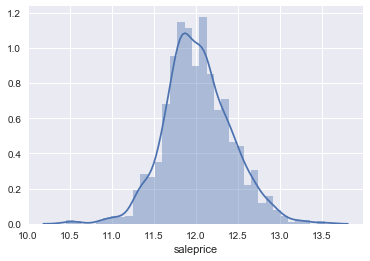

In [129]:
sns.distplot(transformed_features.saleprice)

### Join the datasets back together

In [130]:
all_housing_data = transformed_numeric.merge(housing_dummies, left_index=True,
                                            right_index=True)

In [131]:
#all_housing_data_mean = pd.concat((scaled_X_numeric,housing_dummies),axis=1)

In [145]:
housing_X_transformed = all_housing_data.copy()

In [146]:
housing_y = housing_data_train_numeric.saleprice

In [147]:
housing_X_transformed = housing_X_transformed.drop("saleprice",axis=1)

In [148]:
#transformed_features = transformed_numeric.drop('saleprice', axis=1)

## Training the Model

In [197]:
rf = RandomForestRegressor(n_estimators=50, random_state=123)
cross_val_scores = cross_val_score(rf,housing_X_transformed,housing_y,cv=10)
print "10-fold accuracies:\n",cross_val_scores
print "Mean cv-accuracy:",np.mean(cross_val_scores)
print "Std of cv-accuracy:",np.std(cross_val_scores)

10-fold accuracies:
[ 0.84760161  0.88381035  0.91033938  0.74634993  0.87033147  0.89679419
  0.89525657  0.88473013  0.80686096  0.84379385]
Mean cv-accuracy: 0.858586843536
Std of cv-accuracy: 0.0474896064255


## Trying Grid Search

In [258]:
rf_grid = RandomForestRegressor(n_estimators=50,random_state=123,n_jobs=-1)
max_depth_range = range(1,25)
min_leaf_range = range(1,2)
param_grid = dict(max_depth=max_depth_range,min_samples_leaf = min_leaf_range)
grid = GridSearchCV(rf_grid,param_grid, cv=10, scoring='r2')
grid.fit(housing_X_transformed, housing_y)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'min_samples_leaf': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [259]:
print grid.best_score_
print grid.best_params_
print grid.best_estimator_
#print grid.cv_results_['mean_test_score']
#grid_mean_scores = grid.cv_results_['mean_test_score']
#print grid_mean_scores

0.857351570231
{'max_depth': 14, 'min_samples_leaf': 1}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False)


In [261]:
rf_grid = RandomForestRegressor(n_estimators=50,random_state=123,n_jobs=-1,max_depth=20, min_samples_leaf=1)
rf_grid.fit(housing_X_transformed,housing_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False)

In [262]:
print "R-Squared:",np.sqrt(mean_squared_error(housing_y, rf_grid.predict(housing_X_transformed)))

R-Squared: 10983.3393026


In [ ]:
#y_pred = acc_linreg.predict(X)
#metrics.r2_score(y, y_pred)
#neg_mean_squared_error

## DOING ALL OF THIS AGAIN TO THE TRAINING SET

## Things to try next
1. Using labelencoder instead of creating indicator variables
2. 